In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
import pysindy as ps
from sindy_utils import sindy_library

In [34]:
def Rossler(X, t, P):
    a, b, c = P
    x, y, z = X
    return - y - z, x + a*y, b - c*z + x*z

def Hankel(x, delay):
    N = len(x)
    M = N - delay - 1
    H = np.zeros((delay, M))
    for i in range(delay):
        H[i, :] = x[i:i+M]
    return H

def Solution(func, x0, t, P):
    return odeint(func, x0, t, args = (P,)).T

Generating data for the Rossler system.

In [35]:
a, b, c = 0.15, 0.2, 10
h = np.pi/100
t = np.arange(0,100,h)
n = len(t)
x0 =[0,1,0]
xs,ys,zs = Solution(Rossler, x0, t, [a,b,c])
# from MI criterion:
tau = 17

Based on the Mutual Information and the False Nearest Neighbours criteria, we find the time delayed variables in the embedding space.

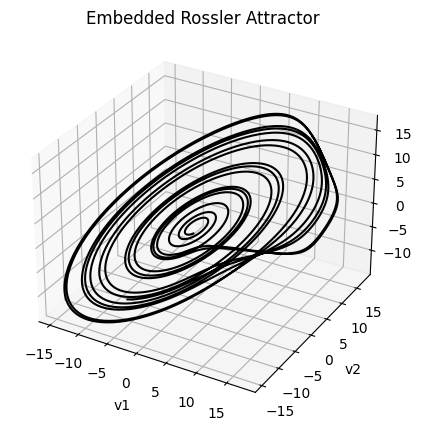

In [36]:
v1 = xs[0: n - 2*tau] #x(t)
v2 = xs[tau: n - tau] #x(t + τ)
v3 = xs[2*tau: n] #x(t + 2τ)

fig = plt.figure(figsize=(9, 5))
ax3d = fig.add_subplot(1, 1, 1, projection='3d')
ax3d.plot(v1, v2, v3, color = "k")
ax3d.set_title("Embedded Rossler Attractor")
ax3d.set_xlabel("v1")
ax3d.set_ylabel("v2")
ax3d.set_zlabel("v3")
plt.show()

Performing a coordinate transformation to the actual space assuming a 3rd order polynomial form.

In [37]:
Phi = np.array([np.ones(len(v1)), v1, v2, v3, v1**2, v2**2, v3**2, v1*v2, v1*v3, v2*v3, v1**3, v2**3, v3**3, v1*v2*v3, v1**2*v2, v2**2*v1, v1**2*v3, v3**2*v1, v2**2*v3, v3**2*v2]).T
x = np.array([xs, ys, zs])
x_train, x_test, library_train, library_test = train_test_split(x[:, :Phi.shape[0]].T, Phi, test_size=0.2, random_state=0, shuffle=False)

Score: 0.9814642608456069


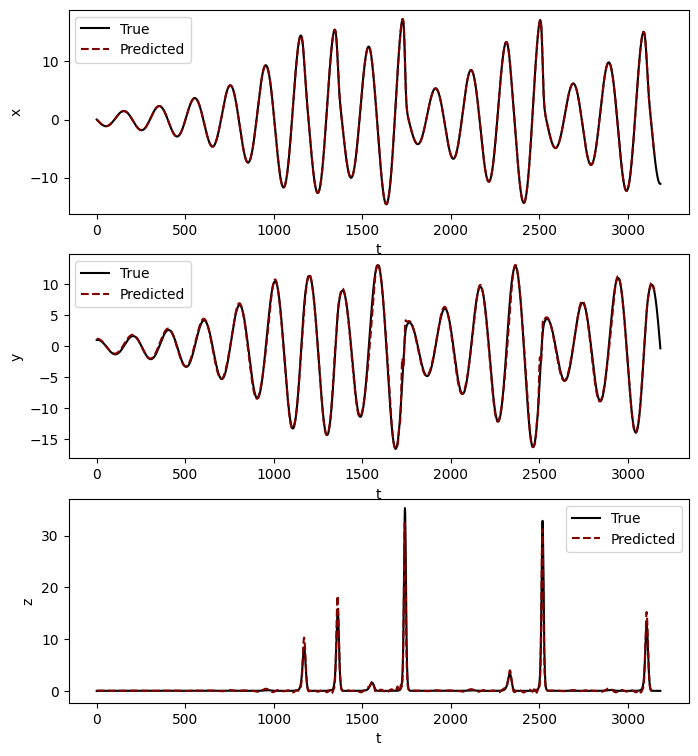

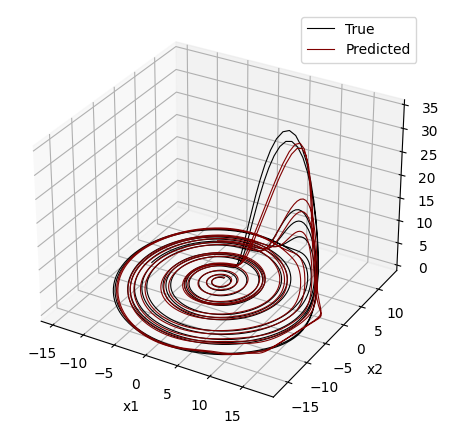

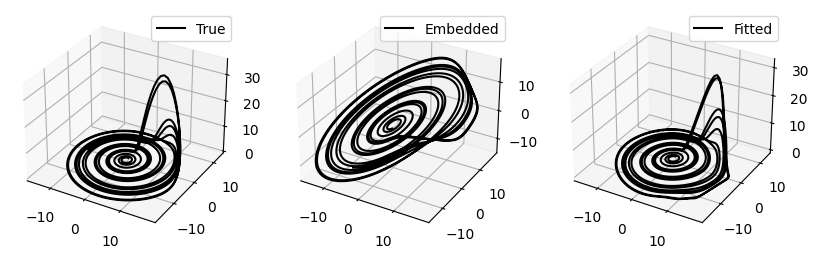

In [50]:
model = Lasso(alpha=1e-2, max_iter= 100000, fit_intercept=False)
model.fit(library_train, x_train)
x_pred = model.predict(Phi).T
score = model.score(library_test, x_test)
print("Score:", score)

fig1, ax = plt.subplots(3, 1, figsize=(8, 9))
fig2 = plt.figure(figsize=(13, 13))
ax3d = fig2.add_subplot(1, 3, 1, projection='3d')
ax[0].plot(x[0], label='True', color = "k")
ax[0].plot(x_pred[0], label='Predicted', linestyle='dashed', color = "maroon")
ax[0].set_xlabel("t")
ax[0].set_ylabel("x")
ax[0].legend()
ax[1].plot(x[1], label='True', color = "k")
ax[1].plot(x_pred[1],linestyle='dashed', color = "maroon", label='Predicted')
ax[1].set_xlabel("t")
ax[1].set_ylabel("y")
ax[1].legend()
ax[2].plot(x[2], label='True', color = "k")
ax[2].plot(x_pred[2], linestyle='dashed', color = "maroon",label='Predicted')
ax[2].set_xlabel("t")
ax[2].set_ylabel("z")
ax[2].legend()
ax3d.plot(x[0], x[1], x[2],lw=.8, color = "k",label='True')
ax3d.plot(x_pred[0], x_pred[1], x_pred[2], lw=.8, color = "maroon",label='Predicted')
ax3d.set_xlabel("x1")
ax3d.set_ylabel("x2")
ax3d.set_zlabel("x3")
ax3d.legend()
plt.tight_layout()
plt.show()

fig3, ax3 = plt.subplots(1, 3, figsize=(10, 9), subplot_kw={'projection': '3d'})
ax3[0].plot(xs, ys, zs, label="True", color = "k")
ax3[1].plot(v1, v2, v3, label="Embedded", color = "k")
ax3[2].plot(x_pred[0], x_pred[1], x_pred[2], label="Fitted",color = "k")
ax3[0].legend()
ax3[1].legend()
ax3[2].legend()
plt.show()

LASSO.

In [39]:
x_trans = x_pred[0]
y_trans = x_pred[1]
z_trans = x_pred[2]
t_trans = t[:len(x_trans)]
print(x_trans.shape)

(3150,)


In [40]:
dx = np.gradient(x_trans, t_trans)
dy = np.gradient(y_trans, t_trans)
dz = np.gradient(z_trans, t_trans)

output = np.array([dx, dy, dz])
input = np.array([np.ones(len(x_trans)), x_trans, y_trans, z_trans, x_trans**2, y_trans**2, z_trans**2, x_trans*y_trans, x_trans*z_trans, y_trans*z_trans]).T

out_train, out_test, in_train, in_test = train_test_split(output[:, :input.shape[0]].T, input, test_size=0.2, random_state=0, shuffle=False)

In [41]:
model = Lasso(alpha=1e-4, max_iter= 1500000, fit_intercept=False)
model.fit(in_train, out_train)
score = model.score(in_test, out_test)
coef = model.coef_
print("Score:", score)

Score: 0.9909561668772126


$$\dot x = - z - y$$
$$\dot y = x + 0.15y$$
$$\dot z = 0.2 -10z + xz$$

In [42]:
library_names = ['1', 'x', 'y', 'z', 'x^2', 'y^2', 'z^2', 'xy', 'xz', 'yz']
var_names = ['x', 'y', 'z'] 
for i in range(len(var_names)):
    eqn = [f'{var_names[i]}_dot = ']
    for j in range(coef.shape[1]):
        if np.abs(coef[i, j]) > 0.07:
            eqn.append(f'+ {coef[i, j]} {library_names[j]} ')
    print(''.join(eqn))

x_dot = + -1.002379180434124 y + -1.7000293490289102 z 
y_dot = + 1.0218595405726423 x + 0.16828126448373554 y + -1.7233629480304629 z + 0.08938929327304382 yz 
z_dot = + 0.33399586389366426 1 + -9.072649270158713 z + -0.08895501250495362 z^2 + 1.0710150451411342 xz + -0.11961110241248465 yz 


In [43]:
def equs(X,t,P):
    x,y,z = X
    x_dot =  -1.0007036923198422 *y + -1.354711493689028 *z 
    y_dot =  0.10091284140983202 + 0.9840780033965116 *x + 0.15440001957190813 *y + -1.260886577747368 *z + 0.0915555428896152 *x*z 
    z_dot =  0.18026943624978586 + -9.256126917052901 *z + 1.0309275358292618 *x*z + -0.10713148988984418 *y*z 
    return x_dot, y_dot, z_dot
x_sin, y_sin, z_sin = Solution(equs, x0, t_trans, [0,0,0])

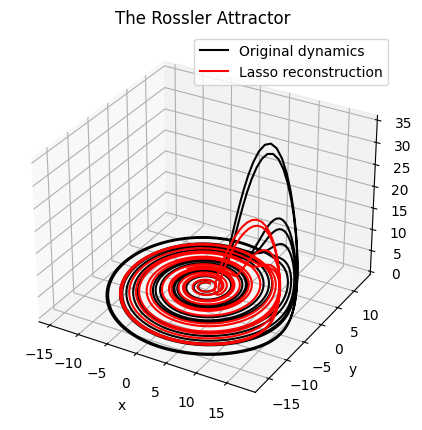

In [44]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection = '3d')
ax.plot(xs[:len(x_sin)], ys[:len(x_sin)],zs[:len(x_sin)],color = 'k', label = "Original dynamics")
ax.plot(x_sin, y_sin,z_sin,color = 'r', label = "Lasso reconstruction")
ax.set_title("The Rossler Attractor")
ax.set_ylabel("y")
ax.set_xlabel("x")
ax.set_zlabel("z")
plt.legend()
plt.show()

SINDy.

In [45]:
X = np.array([x_trans, y_trans, z_trans]).T

diff_method = ps.FiniteDifference(order = 1)
feature_library = ps.PolynomialLibrary(degree = 2)
optimizer = ps.STLSQ(threshold=0.12)

model = ps.SINDy(
    differentiation_method=diff_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y", "z"],
)

model.fit(X, t_trans)
model.print()

(x)' = -0.994 y + -1.029 z
(y)' = 0.999 x + 0.130 y
(z)' = -7.796 z + 1.012 x z + -0.208 y z + -0.121 z^2


In [46]:
def SINDy_equs(X, t, P):
    x, y, z = X
    dx = -0.994 *y + -1.031 *z
    dy = 1.000 *x + 0.130 *y
    dz = 0.659 + -11.589 *z + 1.059 *x *z
    return dx, dy, dz

x_si, y_si, z_si = Solution(SINDy_equs, x0, t_trans, [0,0,0])

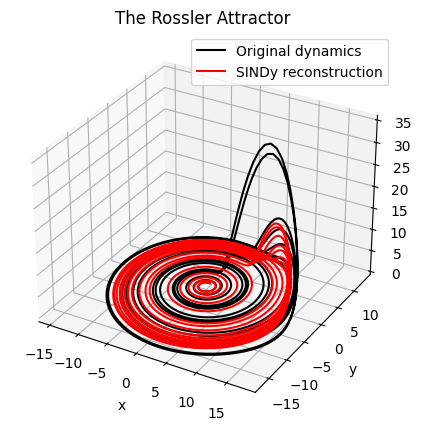

In [47]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection = '3d')
ax.plot(xs[:len(x_si)], ys[:len(x_si)],zs[:len(x_si)],color = 'k', label = "Original dynamics")
ax.plot(x_si, y_si, z_si,color = 'r', label = "SINDy reconstruction")
ax.set_title("The Rossler Attractor")
ax.set_ylabel("y")
ax.set_xlabel("x")
ax.set_zlabel("z")
plt.legend()
plt.show()